In [1]:
import os
import random
import tarfile
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_csv("train.csv")
subset = df.sample(n=50000, random_state=42)
subset.to_csv("subset.csv", index=False)

In [5]:
import tarfile

with tarfile.open("images_000.tar", "r") as tar:
    tar.extractall("train_images")
    members = tar.getnames()  
    print("Total images extracted:", len(members))
    print("First 5 images:", members[:5])


Total images extracted: 8266
First 5 images: ['0/0/0/0000059611c7d079.jpg', '0/0/0/0000070506c174cc.jpg', '0/0/0/000008ae30de967e.jpg', '0/0/0/000014b1f770f640.jpg', '0/0/0/000015f76534add3.jpg']


In [6]:
extracted_ids = []
for root, _, files in os.walk("train_images"):
    for f in files:
        if f.endswith(".jpg"):
            extracted_ids.append(os.path.splitext(f)[0])

print("Total extracted IDs:", len(extracted_ids))
subset = df[df["id"].isin(extracted_ids)]
subset.to_csv("train_subset.csv", index=False)
print("Matching rows:", subset.shape)

Total extracted IDs: 8266
Matching rows: (8266, 3)


In [7]:
df = pd.read_csv("train_subset.csv")
num_classes = df["landmark_id"].nunique()
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])


LabelEncoder()

In [8]:
def get_image_from_number(idx, dataframe, base_path="train_images"):
    fname = dataframe.iloc[idx]["id"] + ".jpg"
    f1, f2, f3 = fname[0], fname[1], fname[2]
    local_path = os.path.join(base_path, f1, f2, f3, fname)
    if not os.path.exists(local_path):
        return None, None
    try:
        img = Image.open(local_path).convert("RGB")
    except:
        return None, None
    label = dataframe.iloc[idx]['landmark_id']
    return img, label

def image_reshape(im, target_size=(224,224)):
    im_resized = im.resize(target_size)
    return np.array(im_resized).astype(np.float32) / 255.0

def get_batch(dataframe, start, batch_size):
    image_array, label_array = [], []
    end_idx = min(start + batch_size, len(dataframe))
    for idx in range(start, end_idx):
        im, label = get_image_from_number(idx, dataframe)
        if im is None or label not in lencoder.classes_:
            continue
        im = image_reshape(im, (224,224))
        image_array.append(im)
        label_array.append(label)
    if len(label_array) == 0:
        return np.array([]), np.array([])
    y_encoded = lencoder.transform(label_array)
    y_onehot = to_categorical(y_encoded, num_classes=num_classes)
    return np.array(image_array), np.array(y_onehot)


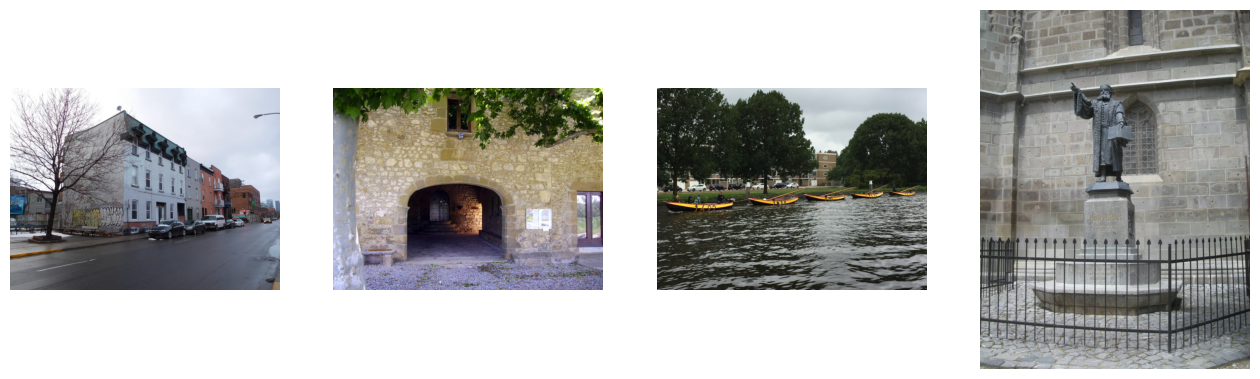

In [9]:
base_path = "./train_images"
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = os.path.join(base_path, ri[0], ri[1], ri[2])
    random_img = random.choice(os.listdir(folder))
    img = Image.open(os.path.join(folder, random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [10]:
source_model = VGG19(weights=None, include_top=False, input_shape=(224,224,3))
model = Sequential()
for layer in source_model.layers:
    model.add(layer)
    if layer.name == "block5_conv4":
        model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

optim1 = RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optim1, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\DEVANSH\miniconda3\envs\IR\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 28,362,324 (108.19 MB)

 Trainable params: 28,361,300 (108.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
df_small = df.sample(n=min(10000, len(df)), random_state=42)
train, val = np.split(df_small.sample(frac=1, random_state=42), [int(0.8*len(df_small))])

C:\Users\DEVANSH\miniconda3\envs\IR\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
batch_size = 32
epochs = 5

for e in range(epochs):
    print(f"\nEpoch {e+1}/{epochs}")
    for i in range(0, len(train), batch_size):
        x_batch, y_batch = get_batch(train, i, batch_size)
        if len(x_batch) == 0:
            continue
        loss, acc = model.train_on_batch(x_batch, y_batch)


Epoch 1/5

Epoch 2/5

Epoch 3/5

Epoch 4/5

Epoch 5/5


In [15]:
x_val, y_val = get_batch(val, 0, len(val))
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


Validation Loss: 8.9235, Validation Accuracy: 0.0018


In [16]:
model.save("trained_model.h5")
print("Model saved as trained_model.h5")

Model saved as trained_model.h5
